In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from functools import partial
from itertools import chain
from tqdm import tqdm
from sklearn.manifold import TSNE
from collections import defaultdict, Counter

from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve

In [2]:
BASE_DATA_DIR = '/home/mikhail/bioinformatics/data/fragment_data'

In [3]:
def group_folds(features, target, group_labels, n_splits=5):
    group_kfold = GroupKFold(n_splits=n_splits)
    
    return group_kfold.split(features, target, group_labels)
    

def stratified_folds(features, target, n_splits=5):
    stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    
    return stratified_kfold.split(features, target)

In [4]:
def run_random_forest(features, target, folds):
    pred = np.zeros_like(target, dtype=np.int)
    pred_proba = np.zeros_like(target, dtype=np.float32)
    
    for train_index, test_index in tqdm(folds):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = target[train_index], target[test_index]

        model = RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=8)
        model.fit(X_train, y_train)
        
        pred[test_index] = model.predict(X_test)
        pred_proba[test_index] = model.predict_proba(X_test)[:, 1]
        
    return pred_proba


def draw_results(target, pred_proba):
    plt.figure(figsize=(20, 10))

    precision, recall, thresholds = precision_recall_curve(target, pred_proba)
    plt.plot(precision, recall, c='r')
    
    xs = np.arange(0, 1.01, 0.1)
    plt.scatter(xs, xs)
    
    plt.figure(figsize=(20, 10))

    plt.hist(pred_proba[target], color='r', alpha=0.5, bins=100, density=True);
    plt.hist(pred_proba[~target], color='b', alpha=0.5, bins=100, density=True);
    
    plt.show()

In [5]:
class Experiment:
    def __init__(self, dataset, dataset_description):
        self.features, self.target, self.pdb_ids, self.chain_ids, self.pair_index, self.feature_description = dataset
        self.experiment_description = [dataset_description]
        self.chain_labels = np.array(['{}_{}'.format(pdb_id, chain_id) 
                                      for pdb_id, chain_id in zip(self.pdb_ids, self.chain_ids)])
    
    def make_experiment(self):
        raise NotImplementedError
    
    def run(self):
        features, target, folds = self.make_experiment()
        
        description = 'Experiment {}'.format('//'.join(self.experiment_description))
        print(description)
        print('target.mean={}'.format(target.mean()))
        
        pred_proba = run_random_forest(features, target, folds)

        draw_results(target, pred_proba)
        
        pair_ids = list(zip(self.pdb_ids, self.chain_ids, self.pair_index))

        return target, pred_proba, pair_ids

    
class SmallChainsExperiment(Experiment):
    def make_experiment(self):
        keys = ['4y4o', '6qzp']
        
        self.experiment_description.append('pdb_ids={} excluded'.format(keys))
        
        mask = ~np.isin(self.pdb_ids, keys)
        
        features = self.features[mask]
        target = self.target[mask]
        group_labels = self.chain_labels[mask]
        folds = group_folds(features, target, group_labels)
        
        return features, target, folds

In [6]:
def load_dataset(data_dir):
    features = np.load(os.path.join(data_dir, 'features.npy'))
    target = np.load(os.path.join(data_dir, 'target.npy'))
    pdb_ids = np.load(os.path.join(data_dir, 'pdb_ids.npy'))
    chain_ids = np.load(os.path.join(data_dir, 'chain_ids.npy'))
    pair_index = [tuple(item) for item in np.load(os.path.join(data_dir, 'pair_index.npy'))]
    
    with open(os.path.join(data_dir, 'description.pickle'), 'rb') as infile:
        feature_description = pickle.load(infile)
    
    return features, target, pdb_ids, chain_ids, pair_index, feature_description


def dataset_descr(exp_id):
    return dict([p.split('=') for p in exp_id.split('.')])

In [7]:
datasets = {}

for exp_id in os.listdir(BASE_DATA_DIR):
    descr = dataset_descr(exp_id)
    
    if descr['es'] == 'bow_wo_distance':
        datasets[descr['dt']] = load_dataset(os.path.join(BASE_DATA_DIR, exp_id))

In [8]:
experiments = {dt: SmallChainsExperiment(dataset, dt) for dt, dataset in datasets.items()}

In [9]:
def get_threshold(approx_precision, target, pred_proba):
    precision, recall, thresholds = precision_recall_curve(target, pred_proba)

    index = np.argmin(np.abs(precision - approx_precision))
    threshold = thresholds[index]

    print(precision[index], recall[index])

    return threshold

In [10]:
approx_precisions = {
    '4': 0.2, 
    '8': 0.32, 
    '11': 0.4
}

0it [00:00, ?it/s]

Experiment 4//pdb_ids=['4y4o', '6qzp'] excluded//pdb_ids=['4y4o', '6qzp'] excluded//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.04419889502762431


5it [00:02,  2.02it/s]


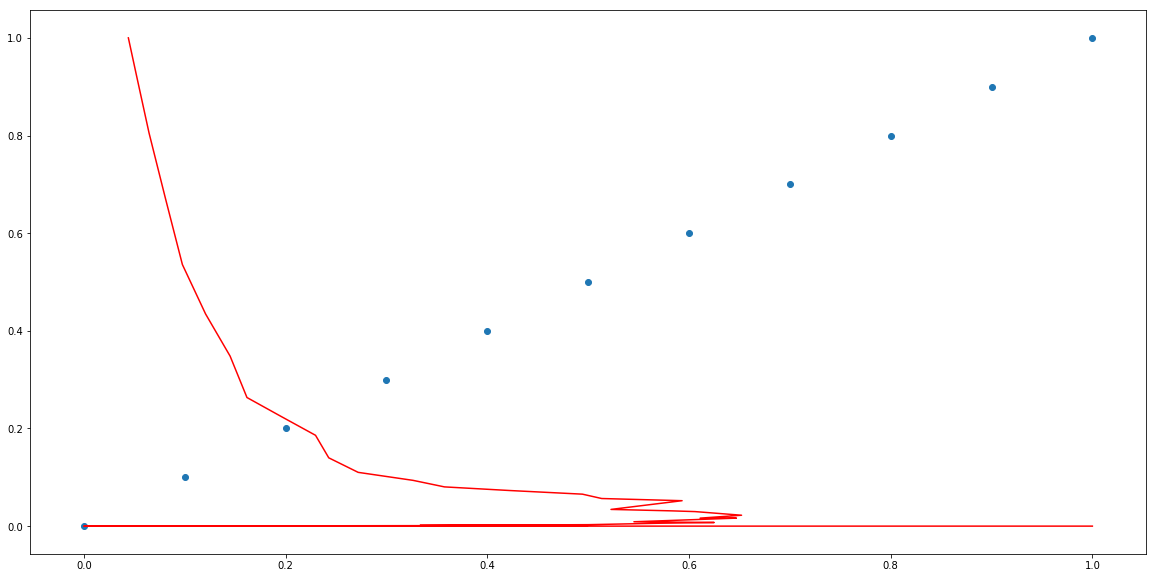

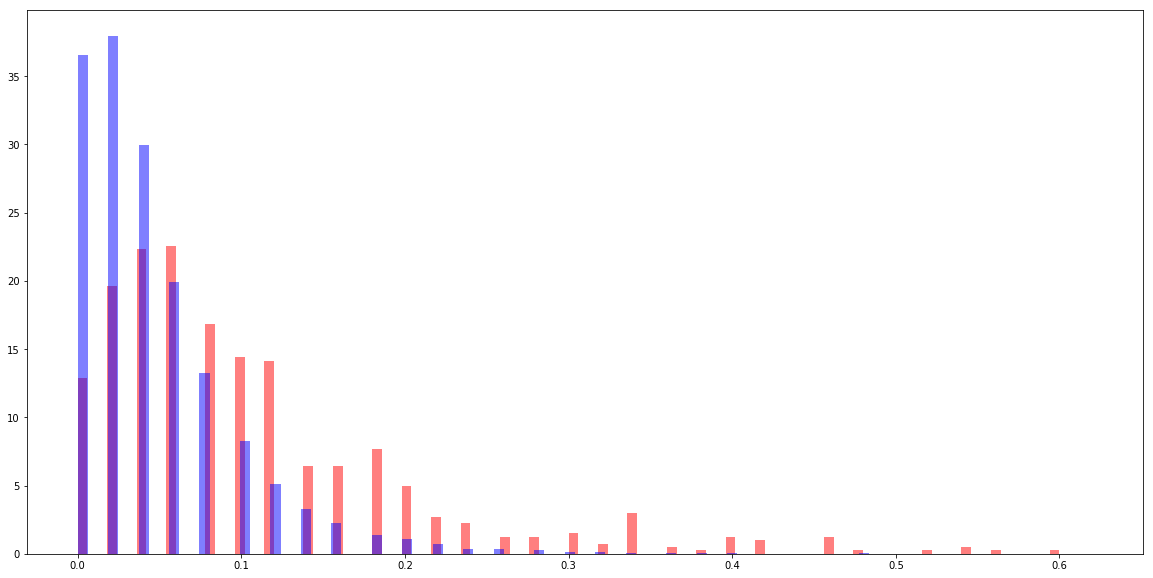

0it [00:00, ?it/s]

0.1955958549222798 0.22470238095238096
shapes:  (15204,) (15204,) 15204
Experiment 8//pdb_ids=['4y4o', '6qzp'] excluded//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.10186941208344621


5it [00:02,  2.00it/s]


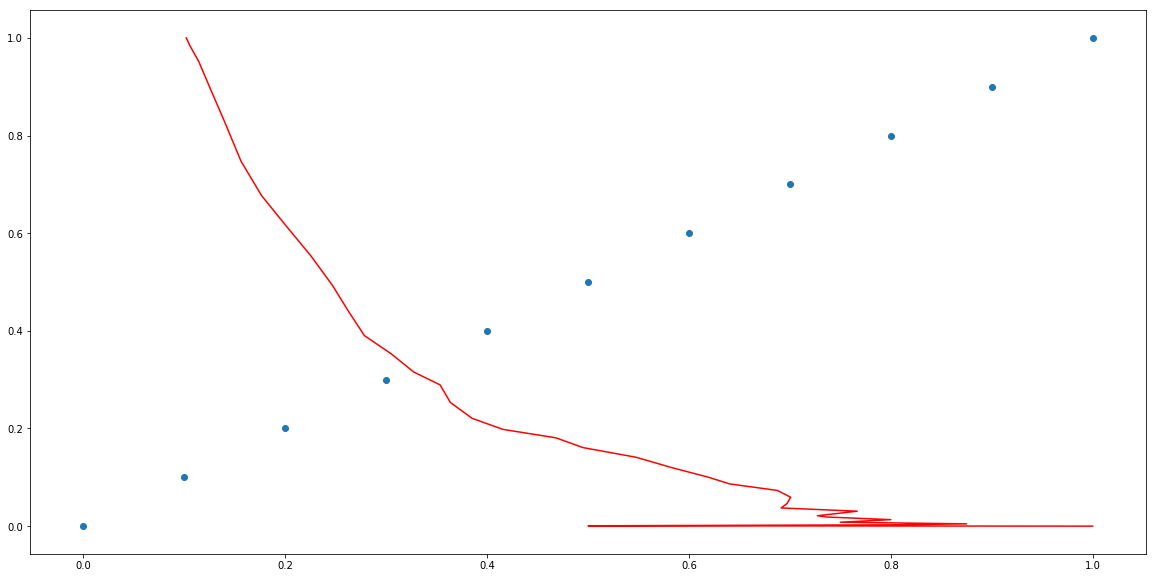

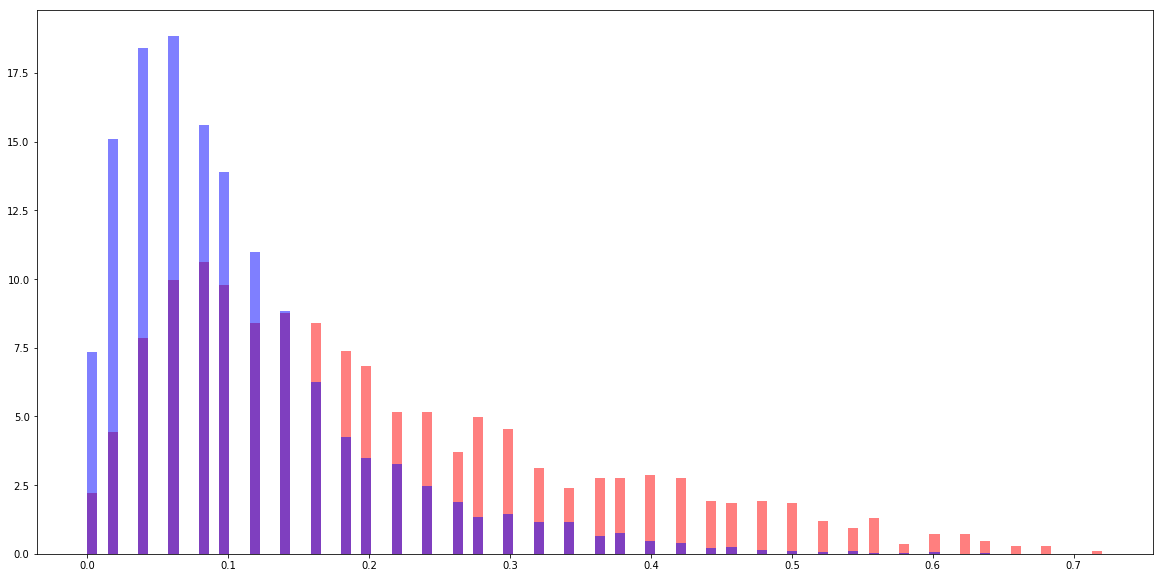

0it [00:00, ?it/s]

0.3271349862258953 0.3158244680851064
shapes:  (14764,) (14764,) 14764
Experiment 11//pdb_ids=['4y4o', '6qzp'] excluded//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.1683381088825215


5it [00:02,  1.98it/s]


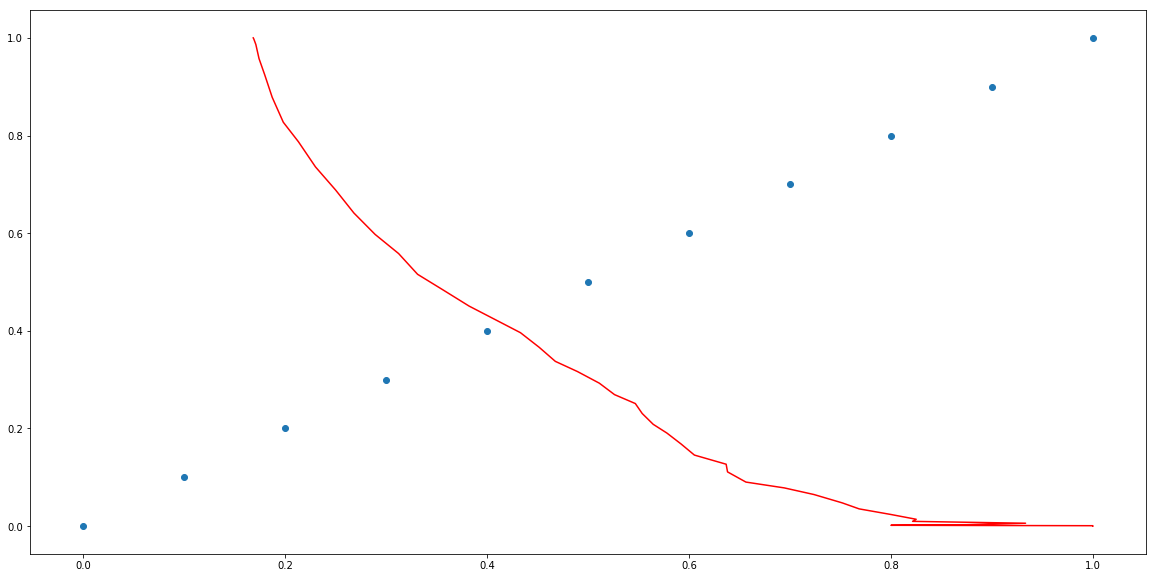

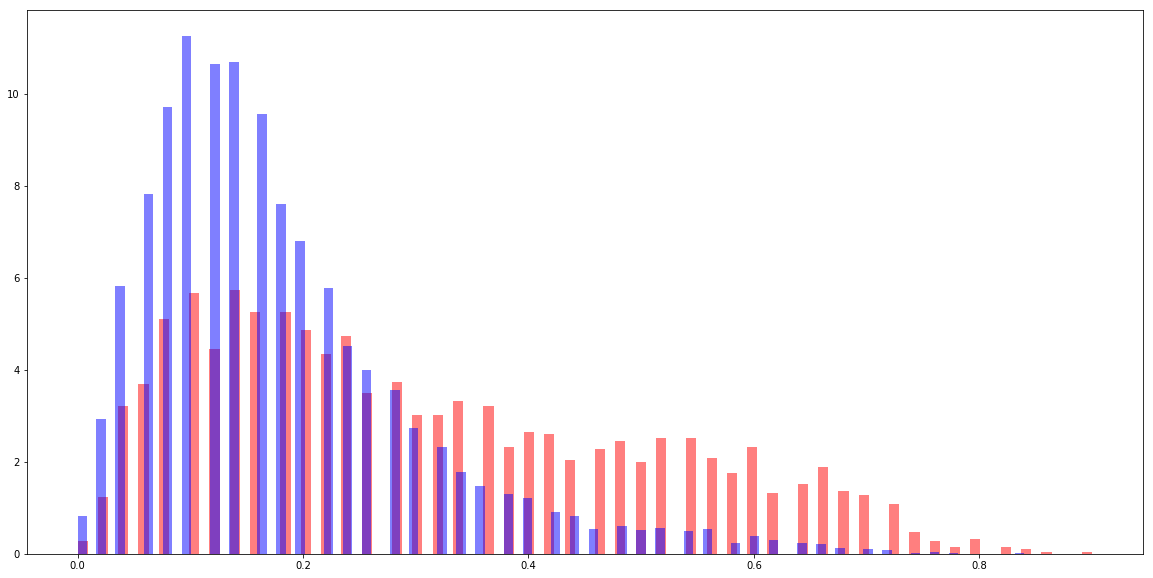

0.40761982793936913 0.42340425531914894
shapes:  (13960,) (13960,) 13960


In [55]:
all_pairs = {}
pairs = defaultdict(list)

for dt in ['4', '8', '11']:
    approx_precision = approx_precisions[dt]
    target, pred_proba, pair_ids = experiments[dt].run()
    threshold = get_threshold(approx_precision, target, pred_proba)
    true_positive = (pred_proba > threshold) & target
    false_negative = (pred_proba <= threshold) & target
    all_pairs[dt] = pair_ids
    
    print('shapes: ', true_positive.shape, false_negative.shape, len(pair_ids))
    for tp, fn, pair_id in zip(true_positive, false_negative, pair_ids):
        if tp:
            pairs[pair_id].append('tp')
        elif fn:
            pairs[pair_id].append('fn')
        else:
            pairs[pair_id].append('na')

In [54]:
pair_ids

[('5x2g', 'B', (5, 7)),
 ('5x2g', 'B', (5, 11)),
 ('5x2g', 'B', (5, 12)),
 ('5x2g', 'B', (5, 13)),
 ('5x2g', 'B', (6, 10)),
 ('5x2g', 'B', (6, 11)),
 ('5x2g', 'B', (6, 12)),
 ('5x2g', 'B', (6, 13)),
 ('5x2g', 'B', (6, 14)),
 ('5x2g', 'B', (7, 5)),
 ('5x2g', 'B', (7, 11)),
 ('5x2g', 'B', (7, 12)),
 ('5x2g', 'B', (7, 13)),
 ('5x2g', 'B', (8, 12)),
 ('5x2g', 'B', (9, 12)),
 ('5x2g', 'B', (9, 13)),
 ('5x2g', 'B', (10, 6)),
 ('5x2g', 'B', (10, 12)),
 ('5x2g', 'B', (11, 5)),
 ('5x2g', 'B', (11, 6)),
 ('5x2g', 'B', (11, 7)),
 ('5x2g', 'B', (12, 5)),
 ('5x2g', 'B', (12, 6)),
 ('5x2g', 'B', (12, 7)),
 ('5x2g', 'B', (12, 8)),
 ('5x2g', 'B', (12, 9)),
 ('5x2g', 'B', (12, 10)),
 ('5x2g', 'B', (12, 14)),
 ('5x2g', 'B', (13, 5)),
 ('5x2g', 'B', (13, 6)),
 ('5x2g', 'B', (13, 7)),
 ('5x2g', 'B', (13, 9)),
 ('5x2g', 'B', (14, 6)),
 ('5x2g', 'B', (14, 12)),
 ('1f1t', 'A', (1, 4)),
 ('1f1t', 'A', (1, 5)),
 ('1f1t', 'A', (2, 4)),
 ('1f1t', 'A', (2, 8)),
 ('1f1t', 'A', (3, 7)),
 ('1f1t', 'A', (3, 8)),
 ('1

In [12]:
everywhere_pairs = set(all_pairs['4']) & set(all_pairs['8']) & set(all_pairs['11'])

In [13]:
counts = Counter([tuple(pairs[pair_id]) for pair_id in everywhere_pairs]).most_common()

In [14]:
[c for c in counts if c[0][0] != 'na'][:4]

[(('fn', 'fn', 'fn'), 341),
 (('fn', 'tp', 'tp'), 90),
 (('tp', 'tp', 'tp'), 82),
 (('fn', 'fn', 'tp'), 71)]

In [15]:
[c for c in counts if c[0][0] == 'na' and c[0][1] != 'na'][:3]

[(('na', 'fn', 'fn'), 402),
 (('na', 'tp', 'tp'), 232),
 (('na', 'fn', 'tp'), 169)]

In [16]:
[c for c in counts if c[0][0] == 'na' and c[0][1] == 'na'][1:]

[(('na', 'na', 'fn'), 569), (('na', 'na', 'tp'), 353)]

0it [00:00, ?it/s]

Experiment 4//pdb_ids=['4y4o', '6qzp'] excluded//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.04419889502762431


5it [00:02,  2.13it/s]


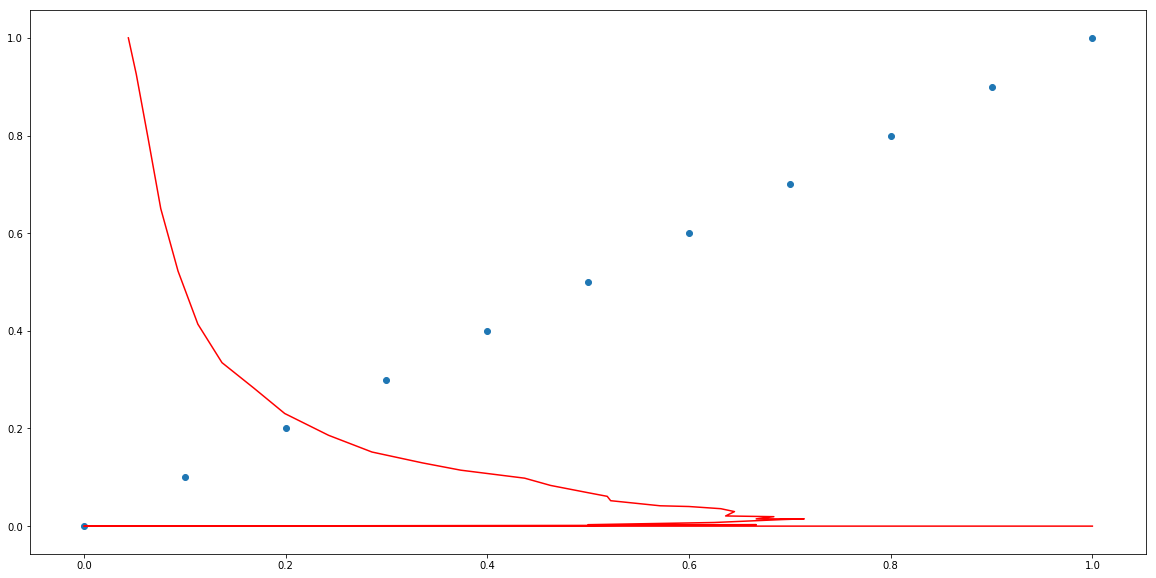

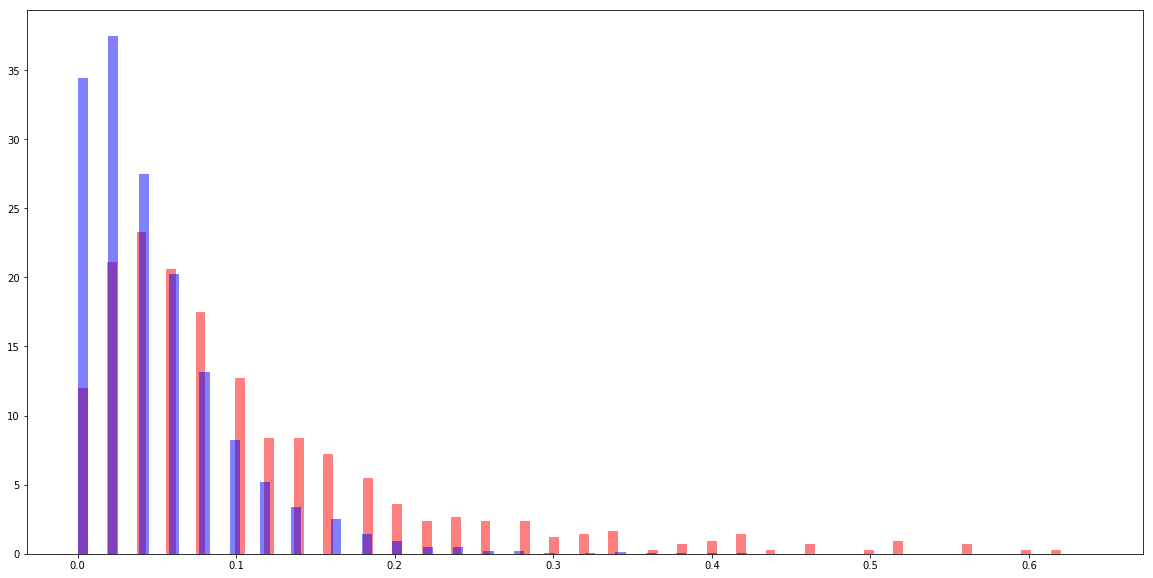

In [17]:
features = defaultdict(list)
_, _, pair_ids = experiments['4'].run()

for f, pair_id in zip(datasets['4'][0], pair_ids):
    signature = tuple(pairs[pair_id])
    features[signature].append(f)

In [18]:
for key, value in features.items():
    features[key] = np.array(value)

In [19]:
signatures = {
    '4': [
        ('fn', 'fn', 'fn'),
        ('fn', 'tp', 'tp'),
        ('tp', 'tp', 'tp'),
        ('fn', 'fn', 'tp'),
    ],
    '8': [
        ('na', 'fn', 'fn'),
        ('na', 'tp', 'tp'),
        ('na', 'fn', 'tp'),
    ],
    '11': [
        ('na', 'na', 'fn'), 
        ('na', 'na', 'tp'),
    ]
}

In [20]:
tsne_features = [
    'sequence lefts[1] length',
    'sequence lefts[1] count of A',
    'sequence lefts[1] count of U',
    'sequence lefts[1] count of G',
    'sequence lefts[1] count of C',
    'sequence lefts[1] count of M',
    'sequence lefts[1] count of N',
    'fragment type lefts[1] for first S',
    'fragment type lefts[1] for first H',
    'fragment type lefts[1] for first B',
    'fragment type lefts[1] for first I',
    'fragment type lefts[1] for first J',
    'fragment type lefts[1] for second C',
    'fragment type lefts[1] for second I',
    'fragment type lefts[1] for second P',
    'sequence rights[1] length',
    'sequence rights[1] count of A',
    'sequence rights[1] count of U',
    'sequence rights[1] count of G',
    'sequence rights[1] count of C',
    'sequence rights[1] count of M',
    'sequence rights[1] count of N',
    'fragment type rights[1] for first S',
    'fragment type rights[1] for first H',
    'fragment type rights[1] for first B',
    'fragment type rights[1] for first I',
    'fragment type rights[1] for first J',
    'fragment type rights[1] for second C',
    'fragment type rights[1] for second I',
    'fragment type rights[1] for second P',
    'relation count SM',
    'relation count LC',
    'relation count LR'
]

tsne_mask = [datasets['4'][-1].index(f) for f in tsne_features]

In [42]:
def visualize(signatures):
    all_features = []
    all_colors = []

    for i, signature in enumerate(signatures):
        all_features.extend(features[signature])
        all_colors.extend([i] * features[signature].shape[0])
    
    all_features = np.array(all_features)[:, tsne_mask]
    all_colors = np.array(all_colors)
    
    normalized_features = (all_features - all_features.mean(axis=0)) / all_features.std(axis=0)
    transformed = TSNE(learning_rate=20, random_state=2).fit_transform(normalized_features)
    
    plt.figure(figsize=(20, 20))

    for i, signature in enumerate(signatures):
        mask = all_colors == i
        plt.scatter(transformed[mask, 0], transformed[mask, 1], label=signature, alpha=0.2, s=200)

    plt.legend()
    
    return all_features, all_colors, transformed

In [43]:
good_pairs = [
    ('fn', 'fn', 'tp'), 
    ('fn', 'tp', 'tp'),
    ('na', 'fn', 'tp'), 
    ('fn', 'fn', 'fn'), 
    ('tp', 'tp', 'tp')
]

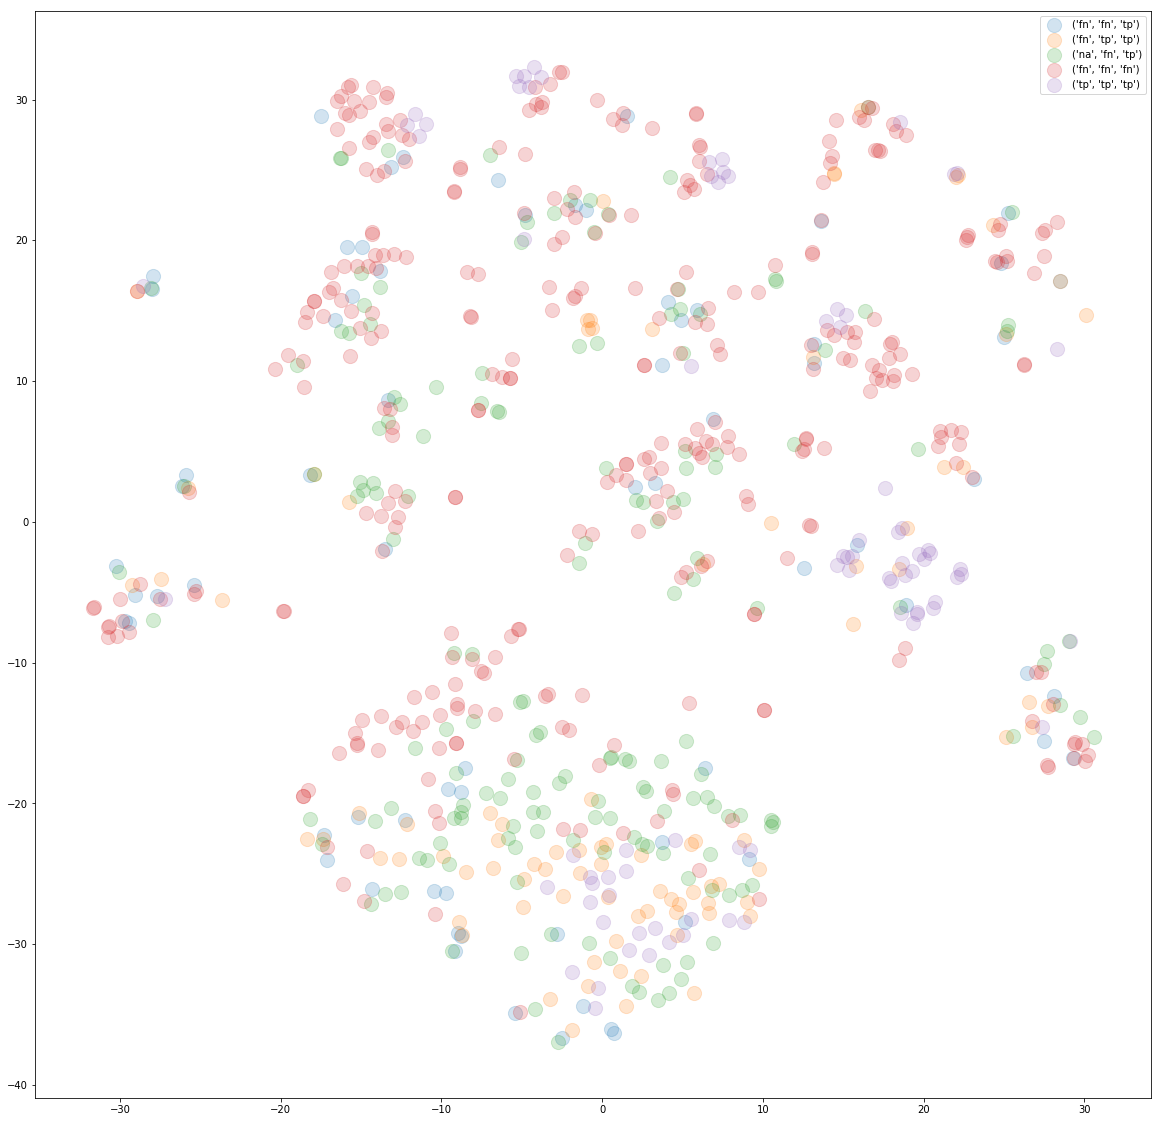

In [44]:
all_features, all_colors, transformed = visualize(good_pairs)

In [45]:
mask = (transformed[:, 1] > -10) & (transformed[:, 1] < 0) & (transformed[:, 0] > 10) & (transformed[:, 1] < 30) & (all_colors == 4)

In [46]:
cluster = all_features[mask]
other = all_features[~mask]

In [47]:
for name, m, s in zip(tsne_features, other.mean(axis=0), other.std(axis=0)):
    print(name, m, s)

sequence lefts[1] length 4.292011019283747 1.9199165156005653
sequence lefts[1] count of A 1.322314049586777 1.3260364273303418
sequence lefts[1] count of U 0.7603305785123967 0.9317609152108415
sequence lefts[1] count of G 1.3181818181818181 1.0778894795049958
sequence lefts[1] count of C 0.8842975206611571 1.0056869914166167
sequence lefts[1] count of M 0.006887052341597796 0.08270200028803446
sequence lefts[1] count of N 5.707988980716253 1.9199165156005653
fragment type lefts[1] for first S 0.5330578512396694 0.4989059815951449
fragment type lefts[1] for first H 0.162534435261708 0.3689403645792437
fragment type lefts[1] for first B 0.05371900826446281 0.22546236141659032
fragment type lefts[1] for first I 0.18181818181818182 0.3856946079199365
fragment type lefts[1] for first J 0.10055096418732783 0.3007332169686728
fragment type lefts[1] for second C 0.3085399449035813 0.46189073091205834
fragment type lefts[1] for second I 0.0440771349862259 0.2052665125090588
fragment type left

In [48]:
for name, m, s in zip(tsne_features, cluster.mean(axis=0), cluster.std(axis=0)):
    print(name, m, s)

sequence lefts[1] length 3.7777777777777777 1.8525924445036737
sequence lefts[1] count of A 1.4814814814814814 1.66378351446046
sequence lefts[1] count of U 1.1111111111111112 0.8314794192830979
sequence lefts[1] count of G 0.8148148148148148 0.771580246518506
sequence lefts[1] count of C 0.37037037037037035 0.823189287810847
sequence lefts[1] count of M 0.0 0.0
sequence lefts[1] count of N 6.222222222222222 1.8525924445036737
fragment type lefts[1] for first S 0.0 0.0
fragment type lefts[1] for first H 0.7777777777777778 0.41573970964154916
fragment type lefts[1] for first B 0.0 0.0
fragment type lefts[1] for first I 0.25925925925925924 0.43822813208145306
fragment type lefts[1] for first J 0.0 0.0
fragment type lefts[1] for second C 0.0 0.0
fragment type lefts[1] for second I 0.0 0.0
fragment type lefts[1] for second P 1.0 0.0
sequence rights[1] length 3.888888888888889 1.987615979999813
sequence rights[1] count of A 1.7407407407407407 1.7969643660308459
sequence rights[1] count of U

1) Классификатор учится на SM/LC/LR -- то есть опять же на фичу расстояния